# API BASICS

In [1]:
from pySubnetSB.api import ModelSpecification, findReferenceInTarget, clusterStructurallyIdenticalModelsInDirectory,  \
        findReferencesInTargets, makeSerializationFile
from pySubnetSB.compatibility_collection_inspector import CompatibilityCollectionInspector
from pySubnetSB.network import Network
import pySubnetSB.constants as cn

import numpy as np
import pandas as pd
import tellurium as te

# Simple Usage

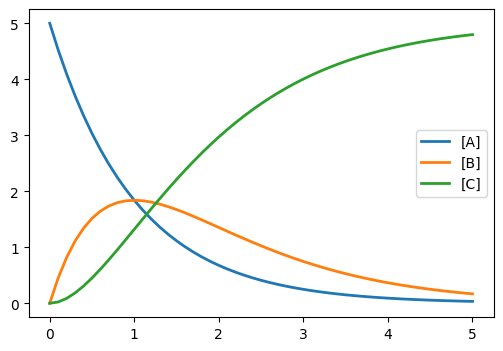

In [2]:
reference_model = """
A -> B; k1*A
B -> C; k2*B

A = 5
B = 0
k1 = 1
k2 = 1
"""
rr = te.loada(reference_model)
rr.simulate()
rr.plot()

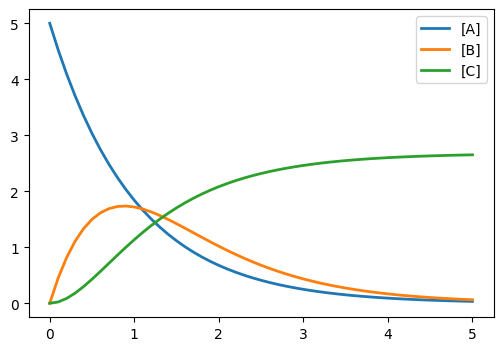

In [3]:
target_model = """
A -> B; k1*A
B -> C; k2*B
B + C -> ; k3*B*C

A = 5
B = 0
k1 = 1
k2 = 1
k3 = 0.2
"""
rr = te.loada(target_model)
rr.simulate()
rr.plot()

In [4]:
result = findReferenceInTarget(reference_model, target_model)


ssignments: 100%|███████████| 8333330/8333330 [00:00<00:00, 29873948164.38it/s]

In [5]:
result

StructurallyIdenticalResult(assignment_pairs=[species: [0 1 2], reaction: [0 1]]; is_truncated=False;

In [6]:
result.assignment_pairs

[species: [0 1 2], reaction: [0 1]]

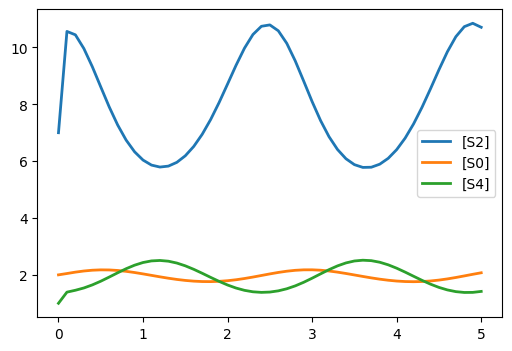

In [7]:
reference_model = """
$S3 -> S2;  S3*19.3591127845924;
S0 -> S4 + S0;  S0*10.3068257839885;
S4 + S2 -> S4;  S4*S2*13.8915863630362;
S2 -> S0 + S2;  S2*0.113616698747501;
S4 + S0 -> S4;  S4*S0*0.240788980014622;
S2 -> S2 + S2;  S2*1.36258363821544;
S2 + S4 -> S2;  S2*S4*1.37438814584166;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;
"""
rr = te.loada(reference_model)
rr.simulate()
rr.plot()

In [8]:
URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1701090001/3/BIOMD0000000695_url.xml"

In [9]:
rr = te.loadSBMLModel(URL)
result = findReferenceInTarget(reference_model, ModelSpecification(rr, specification_type="roadrunner"), is_subnet=True,
        identity=cn.ID_WEAK)

assignments: 100%|██████████| 1785710/1785710 [00:00<00:00, 32979505.50it/s]


We can see all of the mappings of target species to reference speces and target reactions to reference reactions.

In [10]:
result.assignment_pairs

[species: [6 2 8 7], reaction: [12  5 14 23 24 13  6],
 species: [6 2 8 7], reaction: [12  5 15 23 24 13  6],
 species: [6 8 2 7], reaction: [12 23 14  5  6 13 24],
 species: [6 8 2 7], reaction: [12 23 15  5  6 13 24],
 species: [1 7 8 2], reaction: [25  5 29  9 11 27  6],
 species: [1 8 7 2], reaction: [25  9 29  5  6 27 11],
 species: [1 7 8 2], reaction: [25  5 29  9 11 28  6],
 species: [1 8 7 2], reaction: [25  9 29  5  6 28 11],
 species: [0 2 8 1], reaction: [30  5 32 23 24 31  6],
 species: [0 2 8 1], reaction: [30  5 33 23 24 31  6],
 species: [0 2 8 1], reaction: [30  5 34 23 24 31  6],
 species: [0 7 8 1], reaction: [30  5 32  9 11 31  6],
 species: [0 7 8 1], reaction: [30  5 33  9 11 31  6],
 species: [0 7 8 1], reaction: [30  5 34  9 11 31  6],
 species: [0 8 7 1], reaction: [30  9 32  5  6 31 11],
 species: [0 8 7 1], reaction: [30  9 33  5  6 31 11],
 species: [0 8 7 1], reaction: [30  9 34  5  6 31 11],
 species: [0 2 7 1], reaction: [30  9 32 23 24 31 11],
 species: 

We can also see the induced network, a subset of the target network that is structurally identical with the reference network. Note that since we use weak identity, some of the bi-uni reactions in the reference network are assigned to uni-null reactions in the target network.

In [11]:
result.makeInducedNetwork(1)

3247586: 4 species, 7 reactions
  R_13: xFinal_8 -> xFinal_7
  R_6: xFinal_8 -> xFinal_9 + xFinal_8
  R_16: xFinal_7 -> 
  R_24:  -> xFinal_3
  R_25: xFinal_3 -> 
  R_14: xFinal_7 -> 2.0 xFinal_7
  R_7: xFinal_9 -> 

In [13]:
result.makeInducedNetwork(3)

9091999: 4 species, 7 reactions
  R_13: xFinal_8 -> xFinal_7
  R_24:  -> xFinal_3
  R_16: xFinal_7 -> 
  R_6: xFinal_8 -> xFinal_9 + xFinal_8
  R_7: xFinal_9 -> 
  R_14: xFinal_7 -> 2.0 xFinal_7
  R_25: xFinal_3 -> 